In [1]:
!pip install duckdb

In [2]:
%matplotlib inline

# adding project dirs to path so code may be referenced from the notebook
import sys
sys.path.insert(0, '..')

In [3]:
import duckdb
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import config
import utils

# Explore the MAP data
Lets first find out how many forcasts we have downloaded and saved as Parquet files, as well as the start and end dates.  We will use duckdb for this.

In [4]:
%%time
query = f"""
    SELECT 
    count(distinct(reference_time)) as forcast_count,
    min(reference_time) as start_time,
    max(reference_time) as end_time,
    FROM read_parquet('{config.MEDIUM_RANGE_FORCING_PARQUET}/*.parquet')
;"""
print(query)
df = duckdb.query(query).to_df()
df


    SELECT 
    count(distinct(reference_time)) as forcast_count,
    min(reference_time) as start_time,
    max(reference_time) as end_time,
    FROM read_parquet('/home/jovyan/cache/parquet/forcing_medium_range/*.parquet')
;
CPU times: user 16 s, sys: 160 ms, total: 16.1 s
Wall time: 1.17 s


,forcast_count,start_time,end_time
0,128,2022-12-18,2023-01-18 18:00:00


Now look at the assim data.  Lets query the Parquet files to make sure they are all complete.  Each `reference_time` should have 240 `value_times`.

In [5]:
%%time
query = f"""
    SELECT count(distinct(value_time)) as count,
    min(value_time) as start_time,
    max(value_time) as end_time
    FROM read_parquet('{config.FORCING_ANALYSIS_ASSIM_PARQUET}/*.parquet')
;"""
print(query)
df = duckdb.query(query).to_df()
df


    SELECT count(distinct(value_time)) as count,
    min(value_time) as start_time,
    max(value_time) as end_time
    FROM read_parquet('/home/jovyan/cache/parquet/forcing_analysis_assim/*.parquet')
;
CPU times: user 503 ms, sys: 31.2 ms, total: 534 ms
Wall time: 76.1 ms


,count,start_time,end_time
0,960,2022-12-18,2023-01-26 23:00:00


In [6]:
%%time
basins_gdf = utils.parquet_to_gdf(config.HUC10_PARQUET_FILEPATH)

CPU times: user 3.72 s, sys: 13.3 s, total: 17 s
Wall time: 16.7 s


In [7]:
basins_gdf

,objectid,huc10,name,geometry
0,1.0,1016000606,Foster Creek,"POLYGON ((-97.77012 44.94218, -97.76928 44.941..."
1,2.0,0709000208,Badfish Creek,"POLYGON ((-89.42163 42.98052, -89.42130 42.980..."
2,3.0,1806000901,San Antonio Creek,"POLYGON ((-120.47395 34.84828, -120.47387 34.8..."
3,4.0,1805000409,San Mateo Creek-Frontal San Francisco Bay Estu...,"POLYGON ((-122.42777 37.79177, -122.42757 37.7..."
4,5.0,1705010807,Lower Cow Creek,"POLYGON ((-117.26970 43.23085, -117.26954 43.2..."
...,...,...,...,...
16159,19276.0,1805000208,San Pablo Bay,"POLYGON ((-122.28155 38.27869, -122.28162 38.2..."
16160,19277.0,1805000209,Corte Madera Creek-Frontal San Fransisco Bay E...,"MULTIPOLYGON (((-122.59580 38.02898, -122.5957..."
16161,19278.0,1805000210,San Francisco Bay,"POLYGON ((-122.46634 37.99745, -122.46606 37.9..."
16162,19345.0,0313001404,Alligator Harbor,"POLYGON ((-84.33102 29.95428, -84.32967 29.954..."


<AxesSubplot: >

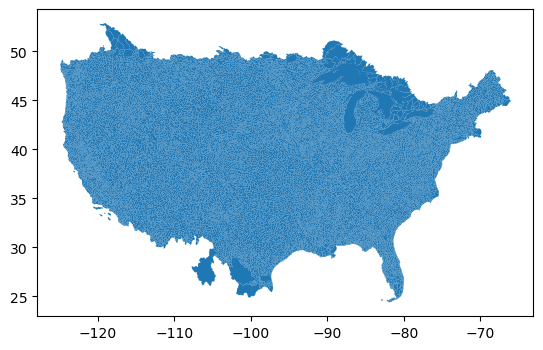

In [8]:
basins_gdf.plot()

In [9]:
# Query some forcast data from parquet files
import importlib
import queries
importlib.reload(queries)

<module 'queries' from '/home/jovyan/temp/hydro-evaluation/src/evaluation/queries/queries.py'>

In [10]:
# query = queries.calculate_catchment_metrics(
#     config.MEDIUM_RANGE_FORCING_PARQUET,
#     config.FORCING_ANALYSIS_ASSIM_PARQUET,
#     group_by=["catchment_id"],
#     order_by=["observed_average"],
#     filters=[
#         {
#             "column": "reference_time",
#             "operator": "=",
#             "value": "2023-01-03 12:00:00"
#         },
#         {
#             "column": "catchment_id",
#             "operator": "like",
#             "value": "18%"
#         }
#     ]
# )


query = queries.calculate_catchment_metrics(
    config.MEDIUM_RANGE_FORCING_PARQUET,
    config.FORCING_ANALYSIS_ASSIM_PARQUET,
    group_by=["catchment_id"],
    order_by=["observed_average"],
    filters=[
        {
            "column": "catchment_id",
            "operator": "like",
            "value": "18%"
        },
        {
            "column": "reference_time",
            "operator": "=",
            "value": "2022-12-25 00:00:00"
        },
    ]
)
print(query)
df = duckdb.query(query).to_df()
df


        WITH joined as (
            SELECT 
                nd.reference_time,
                nd.value_time,
                nd.catchment_id,   
                nd.value as forecast_value, 
                nd.configuration,  
                nd.measurement_unit,     
                nd.variable_name,
                ud.value as observed_value,
                nd.value_time - nd.reference_time as lead_time
            FROM '/home/jovyan/cache/parquet/forcing_medium_range/*.parquet' nd 
            JOIN '/home/jovyan/cache/parquet/forcing_analysis_assim/*.parquet' ud 
                on ud.catchment_id = nd.catchment_id
                and nd.value_time = ud.value_time 
                and nd.measurement_unit = ud.measurement_unit
                and nd.variable_name = ud.variable_name
        )
        SELECT 
            catchment_id,
            regr_intercept(forecast_value, observed_value) as intercept,
            covar_pop(forecast_value, observed_value) as covariance,
        

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,catchment_id,intercept,covariance,corr,r_squared,forecast_count,observed_count,forecast_average,observed_average,forecast_variance,observed_variance,max_forecast_delta,bias
0,1809020107,0.000032,-1.157402e-11,-0.024768,0.000613,240,240,0.000032,5.115208e-07,2.735229e-08,7.983299e-12,0.001094,-0.000031
1,1809020401,0.000040,-4.399643e-11,-0.018183,0.000331,240,240,0.000040,1.767954e-06,3.032814e-08,1.930490e-10,0.000920,-0.000038
2,1809020105,0.000031,-7.116862e-11,-0.030987,0.000960,240,240,0.000030,2.620372e-06,2.479689e-08,2.127328e-10,0.000916,-0.000028
3,1809020104,0.000033,-7.525106e-11,-0.033564,0.001127,240,240,0.000031,3.003525e-06,2.547968e-08,1.972769e-10,0.000960,-0.000028
4,1809020307,0.000034,-4.283208e-11,-0.015387,0.000237,240,240,0.000033,3.506734e-06,1.670182e-08,4.639595e-10,0.000737,-0.000030
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,1804001003,0.000172,1.500176e-07,0.543907,0.295835,240,240,0.000338,3.888092e-04,2.168355e-07,3.508359e-07,-0.000263,0.000050
1005,1802012804,0.000215,1.675463e-07,0.490106,0.240204,240,240,0.000356,3.946540e-04,2.491197e-07,4.691175e-07,-0.002140,0.000039
1006,1804001201,0.000186,1.569458e-07,0.524898,0.275518,240,240,0.000352,3.968691e-04,2.371285e-07,3.770207e-07,-0.000212,0.000045
1007,1804000904,0.000172,1.794513e-07,0.592151,0.350643,240,240,0.000366,3.991244e-04,2.488538e-07,3.690485e-07,-0.000183,0.000033


<AxesSubplot: >

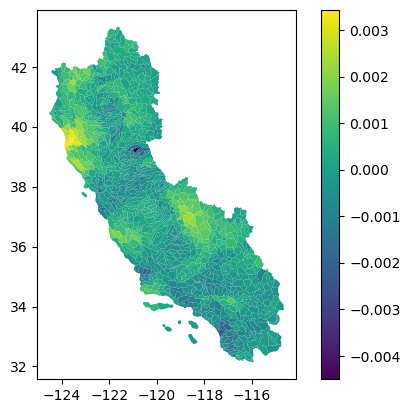

In [11]:
# Join query to basins
gdf_map = basins_gdf.merge(df, left_on="huc10", right_on="catchment_id")

# Filter to CA
# gdf_map = gdf_map.loc[gdf_map["catchment_id"].str.startswith("18")]

gdf_map.plot("max_forecast_delta", legend=True)

In [12]:
query = queries.get_joined_catchment_timeseries(
    config.MEDIUM_RANGE_FORCING_PARQUET,
    config.FORCING_ANALYSIS_ASSIM_PARQUET,
    filters=[
        {
            "column": "reference_time",
            "operator": "=",
            "value": "2023-01-03 12:00:00"
        },
        {
            "column": "catchment_id",
            "operator": "=",
            "value": "1802000502"
        },
    ]
)

df = duckdb.query(query).to_df()
df

,reference_time,value_time,catchment_id,forecast_value,configuration,measurement_unit,variable_name,observed_value,lead_time
0,2023-01-03 12:00:00,2023-01-03 13:00:00,1802000502,0.000016,forcing_medium_range,mm s^-1,precipitation_flux,0.000000,0 days 01:00:00
1,2023-01-03 12:00:00,2023-01-03 14:00:00,1802000502,0.000018,forcing_medium_range,mm s^-1,precipitation_flux,0.000000,0 days 02:00:00
2,2023-01-03 12:00:00,2023-01-03 15:00:00,1802000502,0.000023,forcing_medium_range,mm s^-1,precipitation_flux,0.000000,0 days 03:00:00
3,2023-01-03 12:00:00,2023-01-03 16:00:00,1802000502,0.000018,forcing_medium_range,mm s^-1,precipitation_flux,0.000000,0 days 04:00:00
4,2023-01-03 12:00:00,2023-01-03 17:00:00,1802000502,0.000019,forcing_medium_range,mm s^-1,precipitation_flux,0.000000,0 days 05:00:00
...,...,...,...,...,...,...,...,...,...
235,2023-01-03 12:00:00,2023-01-13 08:00:00,1802000502,0.000000,forcing_medium_range,mm s^-1,precipitation_flux,0.000096,9 days 20:00:00
236,2023-01-03 12:00:00,2023-01-13 09:00:00,1802000502,0.000000,forcing_medium_range,mm s^-1,precipitation_flux,0.000636,9 days 21:00:00
237,2023-01-03 12:00:00,2023-01-13 10:00:00,1802000502,0.000000,forcing_medium_range,mm s^-1,precipitation_flux,0.000188,9 days 22:00:00
238,2023-01-03 12:00:00,2023-01-13 11:00:00,1802000502,0.000000,forcing_medium_range,mm s^-1,precipitation_flux,0.000308,9 days 23:00:00


<AxesSubplot: xlabel='value_time'>

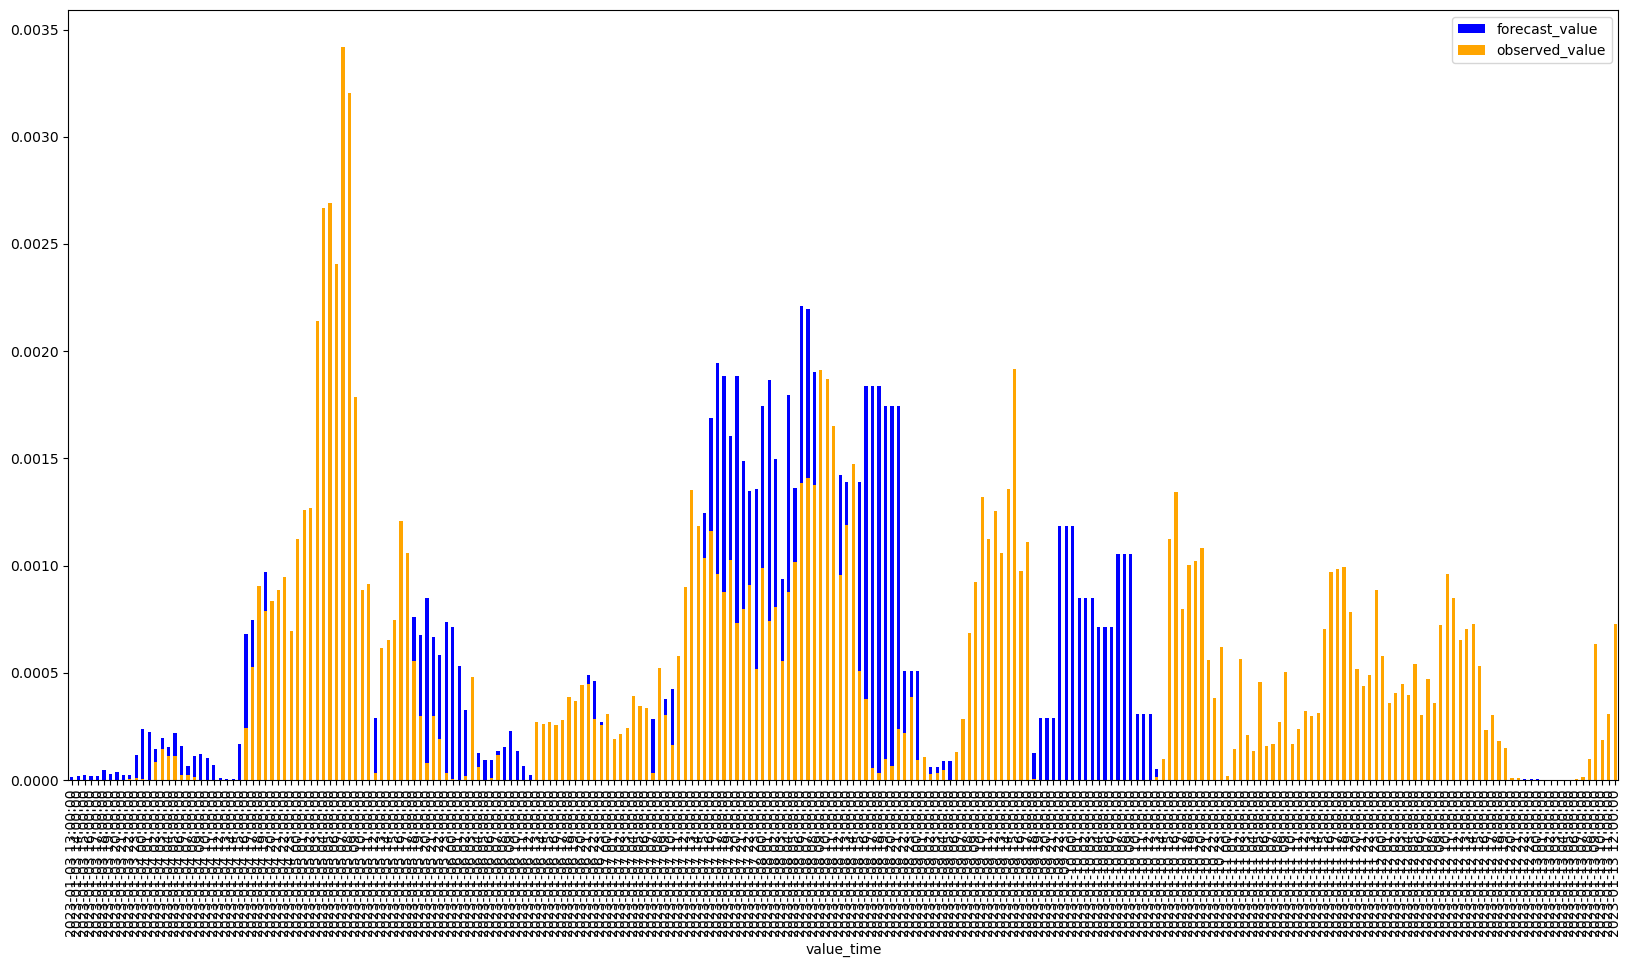

In [13]:
# this is really bad
ax = plt.gca()
df.plot.bar(x= 'value_time', y="forecast_value", ax=ax, figsize=(20,10), color="blue", stacked=True)
df.plot.bar(x= 'value_time', y="observed_value", ax=ax, figsize=(20,10), color="orange", stacked=True)